# Loadings and Cross-loadings

We explore how many samples are necessary to obtain stable cross-loadings, and compare to loadings.

## Setup

In [24]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.filterwarnings(
    'ignore', 'aspect is not supported for Axes with xscale=log, yscale=linear', category=UserWarning
)  # holoviews emits this for log-linear plots
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

import numpy as np
import xarray as xr
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist

from sklearn.utils import check_random_state

from gemmr.data import load_outcomes, print_ds_stats
from gemmr.generative_model import *
from gemmr.sample_analysis import *
from gemmr.estimators import SVDCCA
from gemmr.sample_size import *
from gemmr.metrics import *
from gemmr.util import subset_ds

from matplotlib.patches import Rectangle

import holoviews as hv
from holoviews import opts
hv.renderer('matplotlib').param.set_param(dpi=120)
hv.extension('matplotlib')

from my_config import *

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
ds_cca = load_outcomes('sweep_cca_cca_random_sum+-2+-2')
ds_pls = load_outcomes('sweep_pls_pls_random_sum+-2+-2')

Loading data from subfolder 'gemmr_latest'
Loading data from subfolder 'gemmr_latest'


In [3]:
ds_cca = ds_cca.sel(px=ds_cca.px<128)
ds_pls = ds_pls.sel(px=ds_pls.px<128)

In [4]:
ds_cca = subset_ds(ds_cca, n_keep=25)
ds_pls = subset_ds(ds_pls, n_keep=25)

In [5]:
assert (ds_cca.py == ds_cca.px).where(np.isfinite(ds_cca.py)).all()
assert (ds_pls.py == ds_pls.px).where(np.isfinite(ds_pls.py)).all()

What's in the outcome data? 

In [6]:
print_ds_stats(ds_cca)

n_modes		 1
n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
r		 [0.1 0.3 0.5 0.7]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 4)>
array([[25, 25, 25, 25],
       [25, 25, 25, 25],
       [25, 25, 25, 25],
       [25, 25, 25, 25],
       [25, 25, 25, 25],
       [ 0, 25, 25, 25]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7
  * px       (px) int64 2 4 8 16 32 64

power		calculated


In [7]:
print_ds_stats(ds_pls)

n_modes		 1
n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
r		 [0.1 0.3 0.5 0.7]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 4)>
array([[25, 25, 25, 25],
       [25, 25, 25, 25],
       [25, 25, 25, 25],
       [ 0, 25, 25, 25],
       [ 0, 25, 25, 25],
       [ 0,  0,  0, 10]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7
  * px       (px) int64 2 4 8 16 32 64

power		calculated


## True loadings vs true cross-loadings

How similar are loadings and cross-loadings in principle? We compare here their true values that were calculated directly from the assumed joint covariance matrices (i.e. they were not estimated from data).

In [8]:
def _corr(x, y, corr_fun=pearsonr):
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        return corr_fun(x[mask], y[mask])[0]
    else:
        return np.nan
    
    
def corrs_loading_crossloadings_true(ds, corr_fun=pearsonr):
    return xr.apply_ufunc(
        _corr,
        ds.x_loadings_true,
        ds.x_crossloadings_true,
        input_core_dims=[['x_feature'], ['x_feature']],
        vectorize=True,
        kwargs=dict(corr_fun=corr_fun)
    ) 

In [9]:
cca_pearsonr_loadings_crossloadings_true = corrs_loading_crossloadings_true(ds_cca, pearsonr).mean('Sigma_id').rename('Pearson correlation between\ntrue loadings and\ntrue cross-loadings')
cca_spearmanr_loadings_crossloadings_true = corrs_loading_crossloadings_true(ds_cca, spearmanr).mean('Sigma_id').rename('Spearman correlation between\ntrue loadings and\ntrue cross-loadings')

pls_pearsonr_loadings_crossloadings_true = corrs_loading_crossloadings_true(ds_pls, pearsonr).mean('Sigma_id').rename('Pearson correlation between\ntrue loadings and\ntrue cross-loadings')
pls_spearmanr_loadings_crossloadings_true = corrs_loading_crossloadings_true(ds_pls, spearmanr).mean('Sigma_id').rename('Spearman correlation between\ntrue loadings and\ntrue cross-loadings')

In [10]:
cca_pearsonr_loadings_crossloadings_true = cca_pearsonr_loadings_crossloadings_true.assign_coords(
    px=2 * cca_pearsonr_loadings_crossloadings_true.px
).rename(px='ptot')

pls_pearsonr_loadings_crossloadings_true = pls_pearsonr_loadings_crossloadings_true.assign_coords(
    px=2 * pls_pearsonr_loadings_crossloadings_true.px
).rename(px='ptot')

:QuadMesh   [Number of features,$r_\mathrm{true}$]   (Pearson correlation between
true loadings and
true cross-loadings)
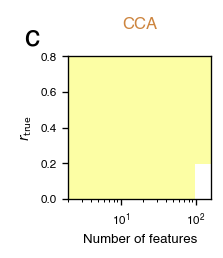

In [11]:
fig_true_cca = (
    hv.QuadMesh(cca_pearsonr_loadings_crossloadings_true, kdims=['ptot', 'r']).opts(hooks=[suptitle_cca])
).redim(
    ptot='Number of features',
    r='$r_\mathrm{true}$'
).opts(*fig_opts).opts(
    opts.QuadMesh(logx=True, cmap='inferno', clim=(0, 1), fig_inches=(1.7, None), sublabel_format='c', sublabel_position=(-.5, .85)),
)

fig_true_cca

In [12]:
handles = []
def horizontal_colorbar(plot, element):
    cax = plot.handles['cax']
    ax = plot.handles['axis']
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, -.2, w, 0.05*h])


:QuadMesh   [Number of features,$r_\mathrm{true}$]   (Pearson correlation between
true loadings and
true cross-loadings)
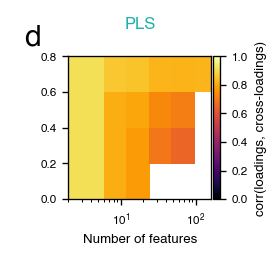

In [13]:
fig_true_pls = (
    hv.QuadMesh(pls_pearsonr_loadings_crossloadings_true, kdims=['ptot', 'r'])
).redim(
    ptot='Number of features',
    r='$r_\mathrm{true}$'
).opts(*fig_opts).opts(
    opts.QuadMesh(
        logx=True, cmap='inferno', clim=(0, 1), clabel="corr(loadings, cross-loadings)", fig_inches=(1.7, None), colorbar=True, 
        colorbar_opts={"orientation":"vertical", "label": ""}, ylabel='', hooks=[suptitle_pls], 
        sublabel_format='d', sublabel_position=(-.5, .85)),
)

fig_true_pls

## How many samples are required to obtain stable cross-loadings, compared to the number of required samples for loadings?

In [14]:
target_error = 0.1

n_reqs_cca = calc_n_required_all_metrics(ds_cca.sel(mode=0), target_error=target_error, search_dim='n_per_ftr')
n_reqs_pls = calc_n_required_all_metrics(ds_pls.sel(mode=0), target_error=target_error, search_dim='n_per_ftr')

n_reqs_cca['crossloadingError'] = calc_n_required(
    mk_crossloadingError(ds_cca).mean('rep'),
    -target_error, target_error, search_dim='n_per_ftr')
n_reqs_pls['crossloadingError'] = calc_n_required(
    mk_crossloadingError(ds_pls).mean('rep'),
    -target_error, target_error, search_dim='n_per_ftr')

In [15]:
pxs_cca = n_reqs_cca['combined'].px
pxs_pls = n_reqs_pls['combined'].px

rel_diff = lambda n_reqs, ref_metric: ((n_reqs['crossloadingError'] - n_reqs[ref_metric]) / n_reqs[ref_metric]).mean('Sigma_id').sel(px=n_reqs[ref_metric].px>2).rename('Required samples per feature\n(cross-loadings - loadings)/loadings')

In [16]:
_rel_diff_cca = rel_diff(n_reqs_cca, 'loadingError')
_rel_diff_cca = _rel_diff_cca.assign_coords(
    px=2 * _rel_diff_cca.px
).rename(px='ptot')

_rel_diff_pls = rel_diff(n_reqs_pls, 'loadingError')
_rel_diff_pls = _rel_diff_pls.assign_coords(
    px=2 * _rel_diff_pls.px
).rename(px='ptot')

:QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required samples per feature
(cross-loadings - loadings)/loadings)
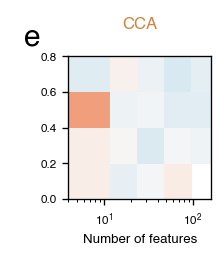

In [17]:
fig_crossloadings_cca = (
    hv.QuadMesh(_rel_diff_cca, kdims=['ptot', 'r'])
).redim(
    ptot='Number of features',
    r='$r_\mathrm{true}$'
).opts(*fig_opts).opts(
    opts.QuadMesh(
        logx=True, logz=False, cmap='RdBu_r', symmetric=True, clim=(-.65, .65), hooks=[suptitle_cca], 
        fig_inches=(1.7, None), ylabel='', colorbar=False, colorbar_opts={"orientation":"vertical"}, 
        sublabel_format='e', sublabel_position=(-.5, .85))
)

fig_crossloadings_cca

:QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required samples per feature
(cross-loadings - loadings)/loadings)
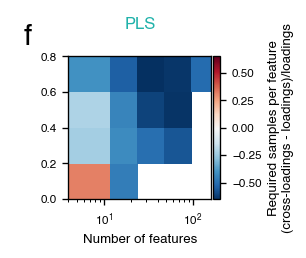

In [18]:
fig_crossloadings_pls = (
    hv.QuadMesh(_rel_diff_pls, kdims=['ptot', 'r'])
).redim(
    ptot='Number of features',
    r='$r_\mathrm{true}$'
).opts(*fig_opts).opts(
    opts.QuadMesh(
        logx=True, logz=False, cmap='RdBu_r', symmetric=True, clim=(-.65, .65), hooks=[suptitle_pls], 
        fig_inches=(1.7, None), ylabel='', colorbar=True, colorbar_opts={"orientation":"vertical"}, 
        sublabel_format='f', sublabel_position=(-.5, .85))
)

fig_crossloadings_pls

## Loadings schematic

In [19]:
rng = check_random_state(42)

n = 100
rXs = [.5, .9, .3, .8]
tX = rng.normal(size=n)
X = np.array([rXs]) * tX.reshape(-1, 1) + rng.normal(size=(n, 4))

rYs = [.7, .2, .8, .9]
tY = rng.normal(size=n)
Y = np.array([rYs]) * tY.reshape(-1, 1) + rng.normal(size=(n, 4))

X.shape, Y.shape

((100, 4), (100, 4))

In [20]:
# extent is used below for figure layout
calc_extent = lambda X, t: max(max(np.abs(X.min(0))), max(np.abs(X.max(0))), np.abs(t.min()), t.max())
extentX = calc_extent(X, tX)
extentY = calc_extent(Y, tY)
print(extentX, extentY)
extent = max(extentX, extentY)

4.190859707165826 4.323160858691789


:Layout
   .Overlay.I    :Overlay
      .Scatter.I :Scatter   [$X$ feature 1]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.II   :Overlay
      .Scatter.I :Scatter   [$X$ feature 2]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.III  :Overlay
      .Scatter.I :Scatter   [$X$ feature 3]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.IV   :Overlay
      .Scatter.I :Scatter   [$X$ feature $p_X$]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.V    :Overlay
      .Scatter.I :Scatter   [$Y$ feature 1]   ($Y$ scores)
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
   .Overlay.VI   :Overlay
      .Scatter.I :Scatter   [$Y$ feature 2]   ($Y$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.VII  :Overlay
      .Scatter.I :Scatter   [$Y$ feature 3]   ($Y$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.VIII :Overlay
      .Scatter.I :Scatter   [$Y$ feature $p_Y$]   ($Y$ scores)
      .Text.I    :Text   [x,y]
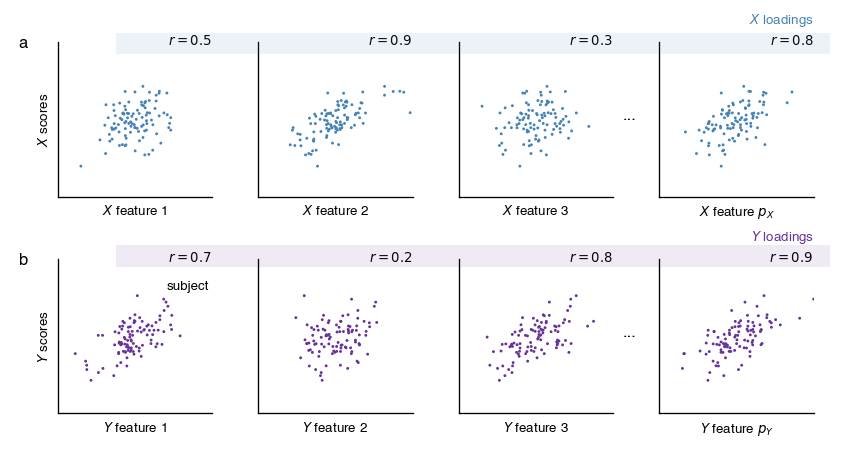

In [21]:
def hook_loadings(plot, element):

    ax = plot.handles['axis']
    fig = plot.handles['fig']
    
    if (ax.get_position().x0 > .75):
        ax.text(-extent-2.05, 0, '...', transform=ax.transData)
    
    if (ax.get_position().x0 > .75) and (ax.get_position().y0 > .5):

        # X loadings
        rect = Rectangle((0.12, 0.90), .85, .05, fill=True, alpha=.1, linewidth=0, linestyle='--', 
                         facecolor='steelblue', transform=fig.transFigure)
        fig.add_artist(rect)
        fig.text(.95, .96, '$X$ loadings', ha='right', va='bottom', fontsize=8, color='steelblue')

        # Y loadings
        rect = Rectangle((0.12, 0.41), .85, .05, fill=True, alpha=.1, linewidth=0, linestyle='--', 
                         facecolor='rebeccapurple', transform=fig.transFigure)
        fig.add_artist(rect)
        fig.text(.95, .46, '$Y$ loadings', ha='right', va='bottom', fontsize=8, color='rebeccapurple')
    
        
figX, figY = hv.Layout(), hv.Layout()
for ri in range(len(rXs)):
    
    r = rXs[ri]
    
    if ri < len(rXs) - 1:
        var_num = ri + 1
    else:
        var_num = r'$p_X$'
    
    panel = (
        hv.Scatter(
            (X[:, ri], tX),
            kdims='$X$ feature {}'.format(var_num),
            vdims='$X$ scores',
        ).opts(color='steelblue')
        * hv.Text(extent, extent+.5, '$r=%.1f$'%r, halign='right', valign='top', fontsize=8)
    )
    
    if ri > 0:
        panel = panel.opts(yaxis='bare')
        panel = panel.opts(sublabel_format='')

    else:
        panel = panel.opts(sublabel_format='a')

    
    figX += panel
    
    #######################################################
    
    r = rYs[ri]
    
    if ri < len(rYs) - 1:
        var_num = ri + 1
    else:
        var_num = r'$p_Y$'
    
    panel = (
        hv.Scatter(
            (Y[:, ri], tY),
            kdims='$Y$ feature {}'.format(var_num),
            vdims='$Y$ scores',
        ).opts(color='rebeccapurple')
        * hv.Text(extent, extent+.5, '$r=%.1f$'%r, halign='right', valign='top', fontsize=8)
    )
    
    if ri == 0:
        panel *= hv.Text(1.8, 2.8, 'subject', halign='left', valign='center', fontsize=8)
        panel = panel.opts(sublabel_format='b')

    if ri > 0:
        panel = panel.opts(yaxis='bare')
        panel = panel.opts(sublabel_format='')
    
    figY += panel
    
    #################################################
    

fig_schematic = (
    figX 
    + figY
).cols(
    4
).opts(fig_opts).opts(
    opts.Scatter(s=3, xticks=0, yticks=0),
    opts.Overlay(xlim=(-extent, extent), ylim=(-extent, extent), hooks=[hook_loadings]),
    opts.Layout(fig_inches=(7, None), hspace=.3, vspace=.25)
)

fig_schematic

:Layout
   .Overlay.I    :Overlay
      .Scatter.I :Scatter   [$X$ feature 1]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.II   :Overlay
      .Scatter.I :Scatter   [$X$ feature 2]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.III  :Overlay
      .Scatter.I :Scatter   [$X$ feature 3]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.IV   :Overlay
      .Scatter.I :Scatter   [$X$ feature $p_X$]   ($X$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.V    :Overlay
      .Scatter.I :Scatter   [$Y$ feature 1]   ($Y$ scores)
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
   .Overlay.VI   :Overlay
      .Scatter.I :Scatter   [$Y$ feature 2]   ($Y$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.VII  :Overlay
      .Scatter.I :Scatter   [$Y$ feature 3]   ($Y$ scores)
      .Text.I    :Text   [x,y]
   .Overlay.VIII :Overlay
      .Scatter.I :Scatter   [$Y$ feature $p_Y$]   ($Y$ scores)
      .Text.I    :Text   [x,y]
   .QuadMesh.I   :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Pearson correlation between
true loadings and
true cross-loadings)
   .QuadMesh.II  :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Pearson correlation between
true loadings and
true cross-loadings)
   .QuadMesh.III :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required samples per feature
(cross-loadings - loadings)/loadings)
   .QuadMesh.IV  :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required samples per feature
(cross-loadings - loadings)/loadings)
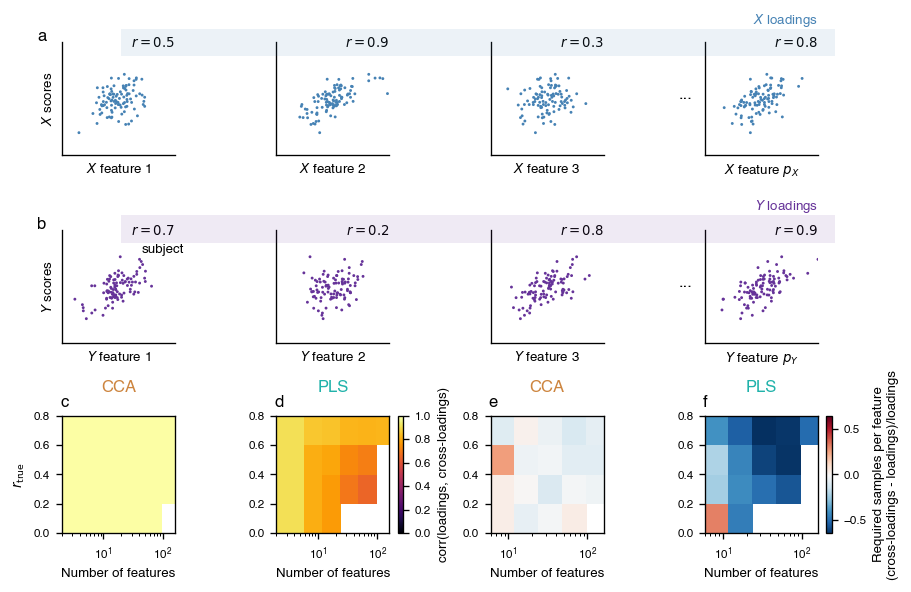

In [22]:
def hook_loadings(plot, element):

    ax = plot.handles['axis']
    fig = plot.handles['fig']
    
    if (ax.get_position().x0 > .75):
        ax.text(-extent-2.05, 0, '...', transform=ax.transData)
    
    if (ax.get_position().x0 > .75) and (ax.get_position().y0 > .5):

        # X loadings
        rect = Rectangle((0.12, 0.92), .85, .05, fill=True, alpha=.1, linewidth=0, linestyle='--', 
                         facecolor='steelblue', transform=fig.transFigure)
        fig.add_artist(rect)
        fig.text(.95, .97, '$X$ loadings', ha='right', va='bottom', fontsize=8, color='steelblue')

        # Y loadings
        rect = Rectangle((0.12, 0.58), .85, .05, fill=True, alpha=.1, linewidth=0, linestyle='--', 
                         facecolor='rebeccapurple', transform=fig.transFigure)
        fig.add_artist(rect)
        fig.text(.95, .63, '$Y$ loadings', ha='right', va='bottom', fontsize=8, color='rebeccapurple')
        
        
fig_combined = (
    fig_schematic.opts(fig_opts).opts(
        opts.Scatter(s=3, xticks=0, yticks=0),
        opts.Overlay(xlim=(-extent, extent), ylim=(-extent, extent), hooks=[hook_loadings]),
    )
    + fig_true_cca.opts(*fig_opts).opts(
        opts.QuadMesh(logx=True, cmap='inferno', clim=(0, 1), sublabel_format='c', sublabel_position=(-.15, .92)),
    )
    + fig_true_pls.opts(*fig_opts).opts(
        opts.QuadMesh(
            logx=True, cmap='inferno', clim=(0, 1), colorbar=True, colorbar_opts={"orientation":"vertical"}, # clabel="", 
            ylabel='', hooks=[suptitle_pls], sublabel_format='d', sublabel_position=(-.15, .92)),
    )
    + fig_crossloadings_cca.opts(*fig_opts).opts(
            opts.QuadMesh(
                logx=True, logz=False, cmap='RdBu_r', symmetric=True, xlim=(6, None), clim=(-.65, .65), 
                hooks=[suptitle_cca], ylabel='', colorbar=False, colorbar_opts={"orientation":"vertical"}, 
                sublabel_format='e', sublabel_position=(-.15, .92))
    )
    + fig_crossloadings_pls.opts(*fig_opts).opts(
        opts.QuadMesh(
            logx=True, logz=False, cmap='RdBu_r', symmetric=True, xlim=(6, None), clim=(-.65, .65), # clabel="", 
            hooks=[suptitle_pls], ylabel='', colorbar=True, colorbar_opts={"orientation":"vertical"}, sublabel_format='f', 
            sublabel_position=(-.15, .92))
    )

).cols(
    4
).opts(*fig_opts).opts(
    opts.Layout(fig_inches=(7, None), hspace=.9, vspace=.6)
)

hv.save(fig_combined, 'fig/figS_loadings.pdf')

fig_combined

In [23]:
hv.save(fig_schematic, 'fig/figS_loadings_AB.svg')
hv.save(fig_true_cca, 'fig/figS_loadings_C.pdf')
hv.save(fig_true_pls, 'fig/figS_loadings_D.pdf')
hv.save(fig_crossloadings_cca, 'fig/figS_loadings_E.pdf')
hv.save(fig_crossloadings_pls, 'fig/figS_loadings_F.pdf')